### gather and format data

In [37]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.contrib.tensor_forest.python import tensor_forest
from tensorflow.python.ops import resources
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import h5py

df = pd.read_csv('sensors_walking.csv')
df.columns = ['1', '2', '3', '4', 'd1', 'd2', 'd3', 'd4', 'hours', 'minutes', 'seconds']

flow = pd.read_csv('flow_walking.csv')
flow.columns = ['Flow']

df.head()

,1,2,3,4,d1,d2,d3,d4,hours,minutes,seconds
0,0.731309,0.751686,0.728809,0.781483,0.105801,0.186839,0.294937,0.345199,10.0,50.0,1.139983
1,0.732341,0.753891,0.731525,0.785005,0.105907,0.188878,0.294519,0.346261,10.0,50.0,1.149434
2,0.733343,0.756291,0.734773,0.788314,0.105901,0.191718,0.297066,0.346372,10.0,50.0,1.158912
3,0.734314,0.758610,0.737137,0.791787,0.105788,0.194066,0.294488,0.347056,10.0,50.0,1.168432
4,0.735255,0.760844,0.740384,0.795052,0.105610,0.196003,0.297086,0.347001,10.0,50.0,1.177880


In [38]:
flow.head()

,Flow
0,3.012306
1,-12.605604
2,-8.539249
3,-10.130252
4,-7.973363


In [39]:
def movingAvg(Class, windowSize):
    """
    Create moving average to remove single outliers

    Args:
        Class (list): List of inhale / exhale classes
        Windowsize (int): Size of moving average window

    Returns:
        filteredClass (list): Filtered list of classes
    """
    
    filteredClass = []
    for i in range(0, len(Class)):

        if i < windowSize - 1:
            filteredClass.append(Class[i])

        elif Class[i] != Class[i - 1]:
            if sum(Class[i - (windowSize - 1):(i + 1)]) / windowSize > 1:
                filteredClass.append(2)

            elif sum(Class[i - (windowSize - 1):(i + 1)]) / windowSize < 1:
                filteredClass.append(0)

            else:
                filteredClass.append(Class[i])

        elif Class[i] == Class[i - 1]:
            filteredClass.append(Class[i])
            
    return filteredClass

def classSwitch(Class):
    """
    Class switch function to filter 3 classifiers down to 2 (inhale and exhale)

    Args:
        Class (list): List of inhale / exhale classes

    Returns:
        decisionClass (list): Filtered (with moving average) of resulting simplified class
    """

    decision = []
    for i in range(0, len(Class)):
        
        if Class[i] == 1:
            decision.append(1)
            
        elif Class[i] == 0:
            decision.append(0)
            
        elif Class[i] == 2:
            if len(decision) > 1:
                decision.append(decision[-1])
            else:
                decision.append(2)
            
    return movingAvg(decision, 3)

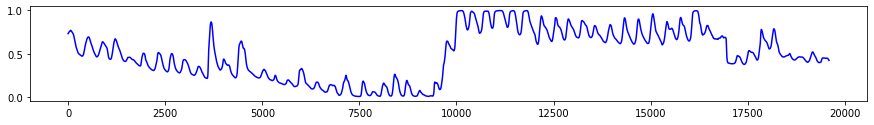

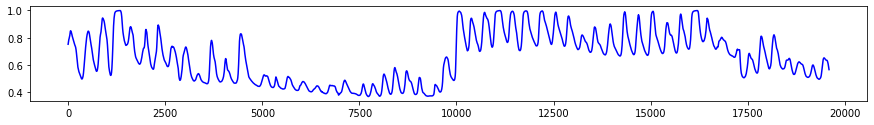

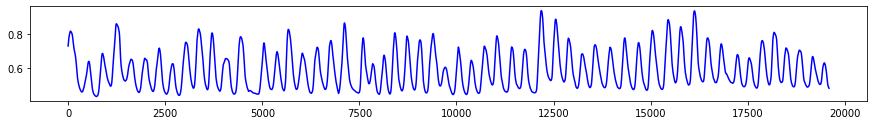

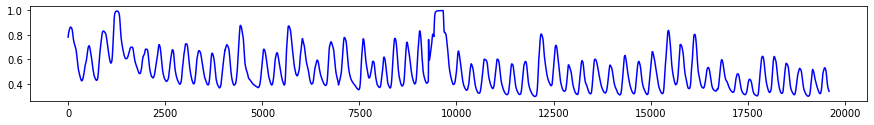

In [40]:
x = range(0, len(df))
fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,1)
plt.plot(x, df['1'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,2)
plt.plot(x, df['2'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,3)
plt.plot(x, df['3'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,4)
plt.plot(x, df['4'], 'b')
plt.show()

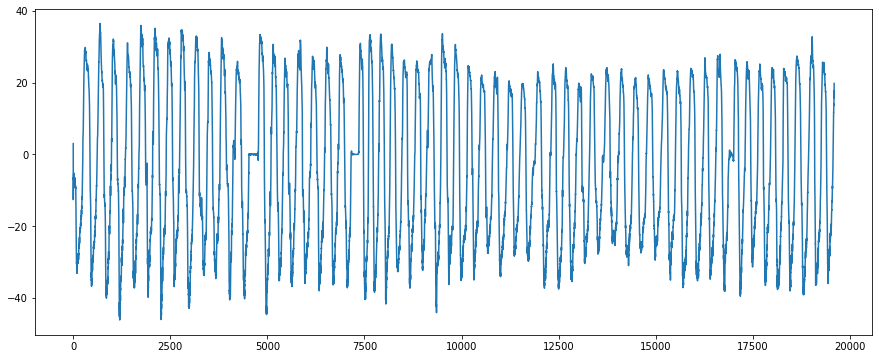

In [41]:
fig = plt.figure(figsize = (15, 6))
plt.plot(flow['Flow'])

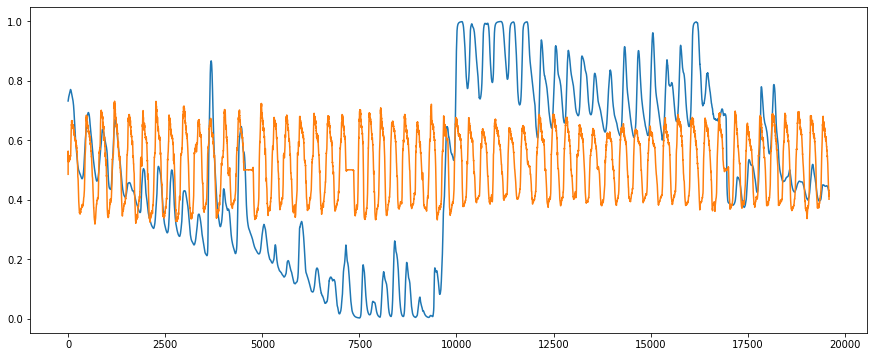

In [42]:
flow['a'] = (flow['Flow'] / 200) - 0.5
fig = plt.figure(figsize = (15, 6))
plt.plot(x, df['1'], x, flow['a']*-1)

In [43]:
flow.drop('a', inplace = True, axis = 1)

In [44]:
def label_fix(label):
    if label < -18:
        return 0
    elif label > 18:
        return 1
    else:
        return 2

df['Class'] = flow['Flow'].apply(label_fix)

In [45]:
df.head()

,1,2,3,4,d1,d2,d3,d4,hours,minutes,seconds,Class
0,0.731309,0.751686,0.728809,0.781483,0.105801,0.186839,0.294937,0.345199,10.0,50.0,1.139983,2
1,0.732341,0.753891,0.731525,0.785005,0.105907,0.188878,0.294519,0.346261,10.0,50.0,1.149434,2
2,0.733343,0.756291,0.734773,0.788314,0.105901,0.191718,0.297066,0.346372,10.0,50.0,1.158912,2
3,0.734314,0.758610,0.737137,0.791787,0.105788,0.194066,0.294488,0.347056,10.0,50.0,1.168432,2
4,0.735255,0.760844,0.740384,0.795052,0.105610,0.196003,0.297086,0.347001,10.0,50.0,1.177880,2


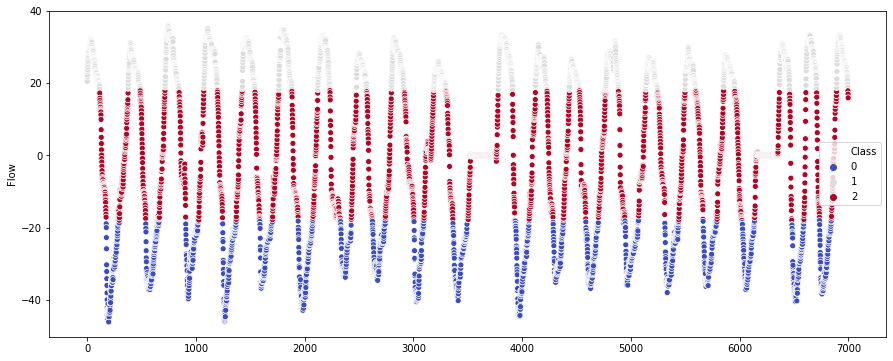

In [46]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow['Flow'][1000:8000], x = range(0, 7000), hue = df['Class'][1000:8000], palette = 'coolwarm')

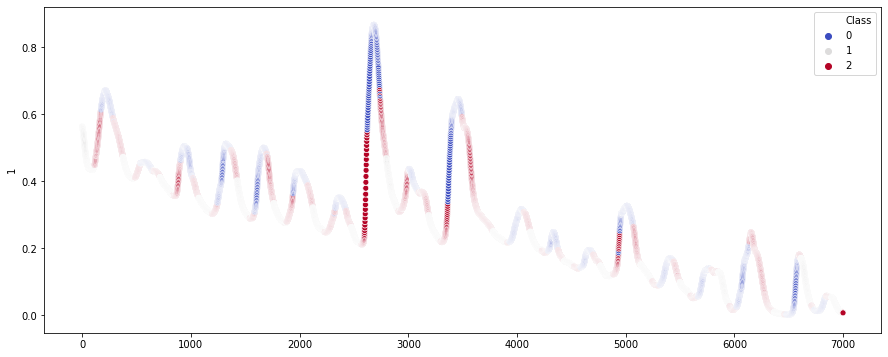

In [47]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = df['1'][1000:8000], x = range(0, 7000), hue = df['Class'][1000:8000], palette = 'coolwarm')

In [48]:
df.head()

,1,2,3,4,d1,d2,d3,d4,hours,minutes,seconds,Class
0,0.731309,0.751686,0.728809,0.781483,0.105801,0.186839,0.294937,0.345199,10.0,50.0,1.139983,2
1,0.732341,0.753891,0.731525,0.785005,0.105907,0.188878,0.294519,0.346261,10.0,50.0,1.149434,2
2,0.733343,0.756291,0.734773,0.788314,0.105901,0.191718,0.297066,0.346372,10.0,50.0,1.158912,2
3,0.734314,0.758610,0.737137,0.791787,0.105788,0.194066,0.294488,0.347056,10.0,50.0,1.168432,2
4,0.735255,0.760844,0.740384,0.795052,0.105610,0.196003,0.297086,0.347001,10.0,50.0,1.177880,2


In [49]:
# Create the data matrix
X = df.drop('Class', axis = 1)
X.drop('hours', inplace = True, axis = 1)
X.drop('minutes', inplace = True, axis = 1)
X.drop('seconds', inplace = True, axis = 1)

# Create the classification matrix
y = df['Class']
y = pd.DataFrame(y, index = None, columns = ['Class'])

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_test.reset_index(inplace = True, drop = True)
y_train.reset_index(inplace = True, drop = True)

In [50]:
len(X)

19595

### model training - deep learning

In [51]:
# Develop keras sequential model with optimized parameters through grid search cv
model = keras.Sequential()
model.add(keras.layers.Dense(150, activation = tf.nn.relu, input_dim = 8))
model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.Dense(125, activation = tf.nn.relu))
#model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(100, activation = tf.nn.relu))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(50, activation = tf.nn.relu))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(3, activation = tf.nn.softmax))

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 150)               1350      
_________________________________________________________________
dropout_3 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               15100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                

In [52]:
EPOCHS = 10000
model.fit(X_train, y_train, epochs = EPOCHS)

Epoch 1/10000
13716/13716 [==============================] - 0s 34us/sample - loss: 0.7590 - acc: 0.6191
Epoch 2/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.6042 - acc: 0.7157
Epoch 3/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.5623 - acc: 0.7458
Epoch 4/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.5387 - acc: 0.7571
Epoch 5/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.5229 - acc: 0.7663
Epoch 6/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.5116 - acc: 0.7732
Epoch 7/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.4982 - acc: 0.7784
Epoch 8/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.4944 - acc: 0.7849
Epoch 9/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.4829 - acc: 0.7857
Epoch 10/10000
13716/13716 [===========================

13716/13716 [==============================] - 0s 25us/sample - loss: 0.2989 - acc: 0.8718
Epoch 79/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.2973 - acc: 0.8708
Epoch 80/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.3063 - acc: 0.8677
Epoch 81/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.2987 - acc: 0.8736
Epoch 82/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2992 - acc: 0.8728
Epoch 83/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.2956 - acc: 0.8772
Epoch 84/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2954 - acc: 0.8736
Epoch 85/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.2944 - acc: 0.8758
Epoch 86/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.2976 - acc: 0.8714
Epoch 87/10000
13716/13716 [==============================] -

13716/13716 [==============================] - 0s 27us/sample - loss: 0.2636 - acc: 0.8887
Epoch 155/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2507 - acc: 0.8969
Epoch 156/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.2572 - acc: 0.8921
Epoch 157/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2573 - acc: 0.8925
Epoch 158/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2511 - acc: 0.8896
Epoch 159/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2569 - acc: 0.8910
Epoch 160/10000
13716/13716 [==============================] - 0s 32us/sample - loss: 0.2523 - acc: 0.8946
Epoch 161/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2588 - acc: 0.8922
Epoch 162/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2534 - acc: 0.8928
Epoch 163/10000
13716/13716 [========================

13716/13716 [==============================] - 0s 27us/sample - loss: 0.2298 - acc: 0.9010
Epoch 231/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.2363 - acc: 0.9045
Epoch 232/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.2348 - acc: 0.9002
Epoch 233/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2310 - acc: 0.9038
Epoch 234/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.2288 - acc: 0.9055
Epoch 235/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2334 - acc: 0.9044
Epoch 236/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2322 - acc: 0.9025
Epoch 237/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2405 - acc: 0.9018
Epoch 238/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.2273 - acc: 0.9049
Epoch 239/10000
13716/13716 [========================

13716/13716 [==============================] - 0s 25us/sample - loss: 0.2231 - acc: 0.9074
Epoch 307/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.2189 - acc: 0.9107
Epoch 308/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.2194 - acc: 0.9119
Epoch 309/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2234 - acc: 0.9084
Epoch 310/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.2211 - acc: 0.9081
Epoch 311/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2172 - acc: 0.9062
Epoch 312/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2187 - acc: 0.9112
Epoch 313/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2220 - acc: 0.9086
Epoch 314/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2227 - acc: 0.9100
Epoch 315/10000
13716/13716 [========================

13716/13716 [==============================] - 0s 26us/sample - loss: 0.2137 - acc: 0.9116
Epoch 383/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2107 - acc: 0.9158
Epoch 384/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2087 - acc: 0.9156
Epoch 385/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2140 - acc: 0.9142
Epoch 386/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2064 - acc: 0.9180
Epoch 387/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2160 - acc: 0.9113
Epoch 388/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2138 - acc: 0.9125
Epoch 389/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2083 - acc: 0.9143
Epoch 390/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2034 - acc: 0.9190
Epoch 391/10000
13716/13716 [========================

13716/13716 [==============================] - 0s 26us/sample - loss: 0.2036 - acc: 0.9169
Epoch 459/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2086 - acc: 0.9137
Epoch 460/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2004 - acc: 0.9206
Epoch 461/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.2007 - acc: 0.9185
Epoch 462/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1996 - acc: 0.9208
Epoch 463/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2073 - acc: 0.9187
Epoch 464/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2052 - acc: 0.9194
Epoch 465/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1951 - acc: 0.9211
Epoch 466/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.2065 - acc: 0.9185
Epoch 467/10000
13716/13716 [========================

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1946 - acc: 0.9225
Epoch 535/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2004 - acc: 0.9210
Epoch 536/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1938 - acc: 0.9237
Epoch 537/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.2012 - acc: 0.9214
Epoch 538/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.2021 - acc: 0.9208
Epoch 539/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1971 - acc: 0.9186
Epoch 540/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1972 - acc: 0.9221
Epoch 541/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1946 - acc: 0.9200
Epoch 542/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1926 - acc: 0.9221
Epoch 543/10000
13716/13716 [========================

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1916 - acc: 0.9212
Epoch 611/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1910 - acc: 0.9244
Epoch 612/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1948 - acc: 0.9234
Epoch 613/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1896 - acc: 0.9245
Epoch 614/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1938 - acc: 0.9254
Epoch 615/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1881 - acc: 0.9231
Epoch 616/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1915 - acc: 0.9256
Epoch 617/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1913 - acc: 0.9247
Epoch 618/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1869 - acc: 0.9256
Epoch 619/10000
13716/13716 [========================

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1874 - acc: 0.9267
Epoch 687/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1859 - acc: 0.9245
Epoch 688/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1872 - acc: 0.9234
Epoch 689/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1788 - acc: 0.9253
Epoch 690/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1870 - acc: 0.9291
Epoch 691/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1864 - acc: 0.9244
Epoch 692/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1848 - acc: 0.9264
Epoch 693/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1855 - acc: 0.9267
Epoch 694/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1861 - acc: 0.9277
Epoch 695/10000
13716/13716 [========================

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1822 - acc: 0.9278
Epoch 763/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1777 - acc: 0.9283
Epoch 764/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1805 - acc: 0.9283
Epoch 765/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1884 - acc: 0.9263
Epoch 766/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1824 - acc: 0.9308
Epoch 767/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1822 - acc: 0.9314
Epoch 768/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1791 - acc: 0.9293
Epoch 769/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1747 - acc: 0.9312
Epoch 770/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1865 - acc: 0.9264
Epoch 771/10000
13716/13716 [========================

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1760 - acc: 0.9303
Epoch 839/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1695 - acc: 0.9325
Epoch 840/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1834 - acc: 0.9256
Epoch 841/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1775 - acc: 0.9291
Epoch 842/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1800 - acc: 0.9275
Epoch 843/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1833 - acc: 0.9310
Epoch 844/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1736 - acc: 0.9285
Epoch 845/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1819 - acc: 0.9290
Epoch 846/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1751 - acc: 0.9304
Epoch 847/10000
13716/13716 [========================

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1844 - acc: 0.9280
Epoch 915/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1753 - acc: 0.9310
Epoch 916/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1749 - acc: 0.9310
Epoch 917/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1734 - acc: 0.9316
Epoch 918/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1787 - acc: 0.9282
Epoch 919/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1756 - acc: 0.9326
Epoch 920/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1633 - acc: 0.9353
Epoch 921/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1732 - acc: 0.9339
Epoch 922/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1765 - acc: 0.9290
Epoch 923/10000
13716/13716 [========================

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1797 - acc: 0.9289
Epoch 991/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1629 - acc: 0.9382
Epoch 992/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1758 - acc: 0.9307
Epoch 993/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1686 - acc: 0.9351
Epoch 994/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1709 - acc: 0.9356
Epoch 995/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1708 - acc: 0.9311
Epoch 996/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1706 - acc: 0.9338
Epoch 997/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1746 - acc: 0.9306
Epoch 998/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1696 - acc: 0.9318
Epoch 999/10000
13716/13716 [========================

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1713 - acc: 0.9328
Epoch 1067/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1588 - acc: 0.9377
Epoch 1068/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1737 - acc: 0.9319
Epoch 1069/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1711 - acc: 0.9332
Epoch 1070/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1730 - acc: 0.9312
Epoch 1071/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1662 - acc: 0.9333
Epoch 1072/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1652 - acc: 0.9333
Epoch 1073/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1664 - acc: 0.9350
Epoch 1074/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1684 - acc: 0.9327
Epoch 1075/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1660 - acc: 0.9338
Epoch 1143/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1674 - acc: 0.9337
Epoch 1144/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1706 - acc: 0.9339
Epoch 1145/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1687 - acc: 0.9336
Epoch 1146/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1717 - acc: 0.9345
Epoch 1147/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1700 - acc: 0.9346
Epoch 1148/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1660 - acc: 0.9340
Epoch 1149/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1708 - acc: 0.9321
Epoch 1150/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1687 - acc: 0.9340
Epoch 1151/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1577 - acc: 0.9398
Epoch 1219/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1670 - acc: 0.9336
Epoch 1220/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1619 - acc: 0.9357
Epoch 1221/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1630 - acc: 0.9372
Epoch 1222/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1718 - acc: 0.9337
Epoch 1223/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1683 - acc: 0.9364
Epoch 1224/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1599 - acc: 0.9363
Epoch 1225/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1692 - acc: 0.9355
Epoch 1226/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1720 - acc: 0.9365
Epoch 1227/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1697 - acc: 0.9334
Epoch 1295/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1624 - acc: 0.9329
Epoch 1296/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1601 - acc: 0.9386
Epoch 1297/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1610 - acc: 0.9387
Epoch 1298/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1635 - acc: 0.9377
Epoch 1299/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1617 - acc: 0.9376
Epoch 1300/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1648 - acc: 0.9366
Epoch 1301/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1678 - acc: 0.9382
Epoch 1302/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1654 - acc: 0.9363
Epoch 1303/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1650 - acc: 0.9378
Epoch 1371/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1649 - acc: 0.9349
Epoch 1372/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1664 - acc: 0.9330
Epoch 1373/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1606 - acc: 0.9396
Epoch 1374/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1684 - acc: 0.9330
Epoch 1375/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1540 - acc: 0.9377
Epoch 1376/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1607 - acc: 0.9374
Epoch 1377/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1643 - acc: 0.9349
Epoch 1378/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1658 - acc: 0.9377
Epoch 1379/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1592 - acc: 0.9379
Epoch 1446/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1612 - acc: 0.9393
Epoch 1447/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1573 - acc: 0.9384
Epoch 1448/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1622 - acc: 0.9365
Epoch 1449/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1624 - acc: 0.9391
Epoch 1450/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1601 - acc: 0.9388
Epoch 1451/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1669 - acc: 0.9374
Epoch 1452/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1703 - acc: 0.9334
Epoch 1453/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1637 - acc: 0.9339
Epoch 1454/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1699 - acc: 0.9338
Epoch 1522/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1630 - acc: 0.9385
Epoch 1523/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1591 - acc: 0.9376
Epoch 1524/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1700 - acc: 0.9368
Epoch 1525/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1576 - acc: 0.9377
Epoch 1526/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1594 - acc: 0.9377
Epoch 1527/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1595 - acc: 0.9401
Epoch 1528/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1638 - acc: 0.9344
Epoch 1529/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1627 - acc: 0.9369
Epoch 1530/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1596 - acc: 0.9368
Epoch 1598/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1536 - acc: 0.9401
Epoch 1599/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1561 - acc: 0.9385
Epoch 1600/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1662 - acc: 0.9342
Epoch 1601/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1562 - acc: 0.9399
Epoch 1602/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1600 - acc: 0.9376
Epoch 1603/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1625 - acc: 0.9369
Epoch 1604/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1573 - acc: 0.9402
Epoch 1605/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1608 - acc: 0.9379
Epoch 1606/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1561 - acc: 0.9392
Epoch 1674/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1503 - acc: 0.9425
Epoch 1675/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1576 - acc: 0.9394
Epoch 1676/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1524 - acc: 0.9398
Epoch 1677/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1560 - acc: 0.9373
Epoch 1678/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1572 - acc: 0.9385
Epoch 1679/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1603 - acc: 0.9396
Epoch 1680/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1595 - acc: 0.9385
Epoch 1681/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1594 - acc: 0.9395
Epoch 1682/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1577 - acc: 0.9386
Epoch 1750/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1564 - acc: 0.9381
Epoch 1751/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1547 - acc: 0.9379
Epoch 1752/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1488 - acc: 0.9429
Epoch 1753/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1523 - acc: 0.9411
Epoch 1754/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1763 - acc: 0.9391
Epoch 1755/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1579 - acc: 0.9390
Epoch 1756/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1615 - acc: 0.9364
Epoch 1757/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1534 - acc: 0.9409
Epoch 1758/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1475 - acc: 0.9433
Epoch 1826/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1562 - acc: 0.9393
Epoch 1827/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1551 - acc: 0.9427
Epoch 1828/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1477 - acc: 0.9428
Epoch 1829/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1604 - acc: 0.9381
Epoch 1830/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1566 - acc: 0.9363
Epoch 1831/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1596 - acc: 0.9381
Epoch 1832/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1567 - acc: 0.9415
Epoch 1833/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1522 - acc: 0.9416
Epoch 1834/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1512 - acc: 0.9409
Epoch 1902/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1588 - acc: 0.9397
Epoch 1903/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1510 - acc: 0.9398
Epoch 1904/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1627 - acc: 0.9385
Epoch 1905/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1611 - acc: 0.9394
Epoch 1906/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1506 - acc: 0.9423
Epoch 1907/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1633 - acc: 0.9394
Epoch 1908/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1570 - acc: 0.9399
Epoch 1909/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1575 - acc: 0.9385
Epoch 1910/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1428 - acc: 0.9418
Epoch 1978/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1557 - acc: 0.9435
Epoch 1979/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1515 - acc: 0.9441
Epoch 1980/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1519 - acc: 0.9436
Epoch 1981/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1480 - acc: 0.9438
Epoch 1982/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1511 - acc: 0.9400
Epoch 1983/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1506 - acc: 0.9412
Epoch 1984/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1567 - acc: 0.9409
Epoch 1985/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1602 - acc: 0.9364
Epoch 1986/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1596 - acc: 0.9418
Epoch 2054/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1493 - acc: 0.9434
Epoch 2055/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1454 - acc: 0.9442
Epoch 2056/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1572 - acc: 0.9401
Epoch 2057/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1542 - acc: 0.9408
Epoch 2058/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1512 - acc: 0.9431
Epoch 2059/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1558 - acc: 0.9407
Epoch 2060/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1527 - acc: 0.9421
Epoch 2061/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1510 - acc: 0.9431
Epoch 2062/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1437 - acc: 0.9455
Epoch 2130/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1452 - acc: 0.9442
Epoch 2131/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1664 - acc: 0.9393
Epoch 2132/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1494 - acc: 0.9438
Epoch 2133/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1510 - acc: 0.9432
Epoch 2134/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1496 - acc: 0.9431
Epoch 2135/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1491 - acc: 0.9428
Epoch 2136/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1434 - acc: 0.9429
Epoch 2137/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1543 - acc: 0.9417
Epoch 2138/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 28us/sample - loss: 0.1523 - acc: 0.9417
Epoch 2205/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1491 - acc: 0.9428
Epoch 2206/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1473 - acc: 0.9440
Epoch 2207/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1482 - acc: 0.9426
Epoch 2208/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1513 - acc: 0.9431
Epoch 2209/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1459 - acc: 0.9456
Epoch 2210/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1515 - acc: 0.9415
Epoch 2211/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1557 - acc: 0.9385
Epoch 2212/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1528 - acc: 0.9428
Epoch 2213/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1506 - acc: 0.9428
Epoch 2280/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1557 - acc: 0.9420
Epoch 2281/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1447 - acc: 0.9436
Epoch 2282/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1508 - acc: 0.9431
Epoch 2283/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1528 - acc: 0.9405
Epoch 2284/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1465 - acc: 0.9437
Epoch 2285/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1535 - acc: 0.9414
Epoch 2286/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1538 - acc: 0.9420
Epoch 2287/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1545 - acc: 0.9422
Epoch 2288/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1450 - acc: 0.9453
Epoch 2356/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1511 - acc: 0.9393
Epoch 2357/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1560 - acc: 0.9408
Epoch 2358/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1426 - acc: 0.9476
Epoch 2359/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1547 - acc: 0.9404
Epoch 2360/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1519 - acc: 0.9449
Epoch 2361/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1509 - acc: 0.9427
Epoch 2362/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1518 - acc: 0.9430
Epoch 2363/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1386 - acc: 0.9485
Epoch 2364/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1496 - acc: 0.9407
Epoch 2432/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1449 - acc: 0.9439
Epoch 2433/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1474 - acc: 0.9444
Epoch 2434/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1513 - acc: 0.9406
Epoch 2435/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1605 - acc: 0.9422
Epoch 2436/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1481 - acc: 0.9447
Epoch 2437/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1423 - acc: 0.9458
Epoch 2438/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1433 - acc: 0.9455
Epoch 2439/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1577 - acc: 0.9407
Epoch 2440/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1518 - acc: 0.9448
Epoch 2508/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1462 - acc: 0.9439
Epoch 2509/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1541 - acc: 0.9409
Epoch 2510/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1451 - acc: 0.9440
Epoch 2511/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1458 - acc: 0.9441
Epoch 2512/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1415 - acc: 0.9445
Epoch 2513/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1506 - acc: 0.9428
Epoch 2514/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1472 - acc: 0.9436
Epoch 2515/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1478 - acc: 0.9445
Epoch 2516/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1467 - acc: 0.9446
Epoch 2584/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1491 - acc: 0.9417
Epoch 2585/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1434 - acc: 0.9456
Epoch 2586/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1482 - acc: 0.9432
Epoch 2587/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1479 - acc: 0.9419
Epoch 2588/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1378 - acc: 0.9471
Epoch 2589/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1441 - acc: 0.9442
Epoch 2590/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1515 - acc: 0.9432
Epoch 2591/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1481 - acc: 0.9450
Epoch 2592/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1398 - acc: 0.9461
Epoch 2660/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1397 - acc: 0.9477
Epoch 2661/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1456 - acc: 0.9429
Epoch 2662/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1465 - acc: 0.9447
Epoch 2663/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1538 - acc: 0.9419
Epoch 2664/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1413 - acc: 0.9465
Epoch 2665/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1443 - acc: 0.9452
Epoch 2666/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1428 - acc: 0.9478
Epoch 2667/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1470 - acc: 0.9449
Epoch 2668/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1507 - acc: 0.9434
Epoch 2736/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1420 - acc: 0.9461
Epoch 2737/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1528 - acc: 0.9426
Epoch 2738/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1420 - acc: 0.9459
Epoch 2739/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1431 - acc: 0.9458
Epoch 2740/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1409 - acc: 0.9466
Epoch 2741/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1440 - acc: 0.9424
Epoch 2742/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1420 - acc: 0.9456
Epoch 2743/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1445 - acc: 0.9445
Epoch 2744/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1433 - acc: 0.9447
Epoch 2812/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1503 - acc: 0.9455
Epoch 2813/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1429 - acc: 0.9460
Epoch 2814/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1491 - acc: 0.9436
Epoch 2815/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1443 - acc: 0.9465
Epoch 2816/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1426 - acc: 0.9485
Epoch 2817/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1473 - acc: 0.9463
Epoch 2818/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1369 - acc: 0.9492
Epoch 2819/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1408 - acc: 0.9451
Epoch 2820/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1473 - acc: 0.9454
Epoch 2888/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1447 - acc: 0.9455
Epoch 2889/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1454 - acc: 0.9444
Epoch 2890/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1373 - acc: 0.9510
Epoch 2891/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1472 - acc: 0.9447
Epoch 2892/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1449 - acc: 0.9500
Epoch 2893/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1461 - acc: 0.9467
Epoch 2894/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1454 - acc: 0.9474
Epoch 2895/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1376 - acc: 0.9465
Epoch 2896/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1390 - acc: 0.9461
Epoch 2964/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1418 - acc: 0.9467
Epoch 2965/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1401 - acc: 0.9432
Epoch 2966/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1456 - acc: 0.9449
Epoch 2967/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1381 - acc: 0.9458
Epoch 2968/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1493 - acc: 0.9445
Epoch 2969/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1427 - acc: 0.9474
Epoch 2970/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1385 - acc: 0.9488
Epoch 2971/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1475 - acc: 0.9444
Epoch 2972/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1430 - acc: 0.9463
Epoch 3040/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1339 - acc: 0.9517
Epoch 3041/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1436 - acc: 0.9459
Epoch 3042/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1435 - acc: 0.9477
Epoch 3043/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1421 - acc: 0.9474
Epoch 3044/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1475 - acc: 0.9457
Epoch 3045/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1448 - acc: 0.9450
Epoch 3046/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1447 - acc: 0.9463
Epoch 3047/10000
13716/13716 [==============================] - 0s 34us/sample - loss: 0.1428 - acc: 0.9462
Epoch 3048/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1442 - acc: 0.9454
Epoch 3116/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1417 - acc: 0.9479
Epoch 3117/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1389 - acc: 0.9484
Epoch 3118/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1417 - acc: 0.9471
Epoch 3119/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1377 - acc: 0.9483
Epoch 3120/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1513 - acc: 0.9448
Epoch 3121/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1404 - acc: 0.9464
Epoch 3122/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1368 - acc: 0.9461
Epoch 3123/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1400 - acc: 0.9442
Epoch 3124/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1414 - acc: 0.9478
Epoch 3192/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1408 - acc: 0.9460
Epoch 3193/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1493 - acc: 0.9452
Epoch 3194/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1412 - acc: 0.9461
Epoch 3195/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1444 - acc: 0.9431
Epoch 3196/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1365 - acc: 0.9434
Epoch 3197/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1425 - acc: 0.9453
Epoch 3198/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1421 - acc: 0.9463
Epoch 3199/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1423 - acc: 0.9443
Epoch 3200/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 33us/sample - loss: 0.1376 - acc: 0.9494
Epoch 3268/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1417 - acc: 0.9475
Epoch 3269/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1393 - acc: 0.9461
Epoch 3270/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1469 - acc: 0.9447
Epoch 3271/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1418 - acc: 0.9466
Epoch 3272/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1396 - acc: 0.9476
Epoch 3273/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1490 - acc: 0.9452
Epoch 3274/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1369 - acc: 0.9486
Epoch 3275/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1409 - acc: 0.9474
Epoch 3276/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1417 - acc: 0.9479
Epoch 3344/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1476 - acc: 0.9471
Epoch 3345/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1379 - acc: 0.9492
Epoch 3346/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1500 - acc: 0.9424
Epoch 3347/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1453 - acc: 0.9428
Epoch 3348/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1433 - acc: 0.9445
Epoch 3349/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1369 - acc: 0.9493
Epoch 3350/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1404 - acc: 0.9471
Epoch 3351/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1418 - acc: 0.9463
Epoch 3352/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1352 - acc: 0.9494
Epoch 3419/10000
13716/13716 [==============================] - 0s 35us/sample - loss: 0.1411 - acc: 0.9460
Epoch 3420/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1432 - acc: 0.9483
Epoch 3421/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1468 - acc: 0.9441
Epoch 3422/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1369 - acc: 0.9477
Epoch 3423/10000
13716/13716 [==============================] - 0s 30us/sample - loss: 0.1464 - acc: 0.9442
Epoch 3424/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1396 - acc: 0.9463
Epoch 3425/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1463 - acc: 0.9460
Epoch 3426/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1377 - acc: 0.9471
Epoch 3427/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1490 - acc: 0.9466
Epoch 3495/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1354 - acc: 0.9482
Epoch 3496/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1454 - acc: 0.9452
Epoch 3497/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1427 - acc: 0.9458
Epoch 3498/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1481 - acc: 0.9441
Epoch 3499/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1458 - acc: 0.9469
Epoch 3500/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1417 - acc: 0.9474
Epoch 3501/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1342 - acc: 0.9497
Epoch 3502/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1340 - acc: 0.9490
Epoch 3503/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 29us/sample - loss: 0.1390 - acc: 0.9475
Epoch 3571/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1411 - acc: 0.9471
Epoch 3572/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1389 - acc: 0.9465
Epoch 3573/10000
13716/13716 [==============================] - 0s 30us/sample - loss: 0.1466 - acc: 0.9450
Epoch 3574/10000
13716/13716 [==============================] - 0s 31us/sample - loss: 0.1390 - acc: 0.9458
Epoch 3575/10000
13716/13716 [==============================] - 0s 31us/sample - loss: 0.1320 - acc: 0.9503
Epoch 3576/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1479 - acc: 0.9432
Epoch 3577/10000
13716/13716 [==============================] - 0s 31us/sample - loss: 0.1414 - acc: 0.9464
Epoch 3578/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1470 - acc: 0.9468
Epoch 3579/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1395 - acc: 0.9490
Epoch 3646/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1420 - acc: 0.9480
Epoch 3647/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1367 - acc: 0.9473
Epoch 3648/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1431 - acc: 0.9467
Epoch 3649/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1396 - acc: 0.9463
Epoch 3650/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1417 - acc: 0.9466
Epoch 3651/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1420 - acc: 0.9474
Epoch 3652/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1420 - acc: 0.9455
Epoch 3653/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1356 - acc: 0.9504
Epoch 3654/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1444 - acc: 0.9441
Epoch 3722/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1399 - acc: 0.9477
Epoch 3723/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1501 - acc: 0.9444
Epoch 3724/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1424 - acc: 0.9474
Epoch 3725/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1342 - acc: 0.9482
Epoch 3726/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1354 - acc: 0.9488
Epoch 3727/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1409 - acc: 0.9499
Epoch 3728/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1348 - acc: 0.9498
Epoch 3729/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1351 - acc: 0.9479
Epoch 3730/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1475 - acc: 0.9431
Epoch 3798/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1443 - acc: 0.9470
Epoch 3799/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1426 - acc: 0.9470
Epoch 3800/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1352 - acc: 0.9492
Epoch 3801/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1487 - acc: 0.9451
Epoch 3802/10000
13716/13716 [==============================] - 0s 31us/sample - loss: 0.1353 - acc: 0.9468
Epoch 3803/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1329 - acc: 0.9499
Epoch 3804/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1351 - acc: 0.9478
Epoch 3805/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1424 - acc: 0.9460
Epoch 3806/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1429 - acc: 0.9485
Epoch 3874/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1449 - acc: 0.9490
Epoch 3875/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1330 - acc: 0.9500
Epoch 3876/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1350 - acc: 0.9498
Epoch 3877/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1353 - acc: 0.9516
Epoch 3878/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1381 - acc: 0.9472
Epoch 3879/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1408 - acc: 0.9495
Epoch 3880/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1385 - acc: 0.9455
Epoch 3881/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1412 - acc: 0.9460
Epoch 3882/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1433 - acc: 0.9482
Epoch 3950/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1379 - acc: 0.9495
Epoch 3951/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1340 - acc: 0.9485
Epoch 3952/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1391 - acc: 0.9471
Epoch 3953/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1337 - acc: 0.9506
Epoch 3954/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1416 - acc: 0.9452
Epoch 3955/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1381 - acc: 0.9477
Epoch 3956/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1484 - acc: 0.9440
Epoch 3957/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1386 - acc: 0.9475
Epoch 3958/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 28us/sample - loss: 0.1482 - acc: 0.9479
Epoch 4026/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1394 - acc: 0.9490
Epoch 4027/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1407 - acc: 0.9453
Epoch 4028/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1429 - acc: 0.9489
Epoch 4029/10000
13716/13716 [==============================] - 0s 32us/sample - loss: 0.1409 - acc: 0.9468
Epoch 4030/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1410 - acc: 0.9480
Epoch 4031/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1384 - acc: 0.9487
Epoch 4032/10000
13716/13716 [==============================] - 0s 35us/sample - loss: 0.1406 - acc: 0.9479
Epoch 4033/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1374 - acc: 0.9477
Epoch 4034/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 32us/sample - loss: 0.1280 - acc: 0.9498
Epoch 4102/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1353 - acc: 0.9488
Epoch 4103/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1399 - acc: 0.9469
Epoch 4104/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1392 - acc: 0.9479
Epoch 4105/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1314 - acc: 0.9515
Epoch 4106/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1381 - acc: 0.9496
Epoch 4107/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1402 - acc: 0.9463
Epoch 4108/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1377 - acc: 0.9487
Epoch 4109/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1400 - acc: 0.9450
Epoch 4110/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1343 - acc: 0.9493
Epoch 4178/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1393 - acc: 0.9469
Epoch 4179/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1357 - acc: 0.9505
Epoch 4180/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1378 - acc: 0.9486
Epoch 4181/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1311 - acc: 0.9509
Epoch 4182/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1343 - acc: 0.9505
Epoch 4183/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1423 - acc: 0.9493
Epoch 4184/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1347 - acc: 0.9485
Epoch 4185/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1430 - acc: 0.9479
Epoch 4186/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1336 - acc: 0.9497
Epoch 4254/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1348 - acc: 0.9487
Epoch 4255/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1440 - acc: 0.9456
Epoch 4256/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1408 - acc: 0.9467
Epoch 4257/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1316 - acc: 0.9492
Epoch 4258/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1428 - acc: 0.9453
Epoch 4259/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1370 - acc: 0.9479
Epoch 4260/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1330 - acc: 0.9474
Epoch 4261/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1369 - acc: 0.9489
Epoch 4262/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1354 - acc: 0.9485
Epoch 4330/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1393 - acc: 0.9458
Epoch 4331/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1319 - acc: 0.9525
Epoch 4332/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1417 - acc: 0.9467
Epoch 4333/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1406 - acc: 0.9465
Epoch 4334/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1372 - acc: 0.9480
Epoch 4335/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1343 - acc: 0.9485
Epoch 4336/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1376 - acc: 0.9490
Epoch 4337/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1410 - acc: 0.9490
Epoch 4338/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1436 - acc: 0.9470
Epoch 4406/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1289 - acc: 0.9516
Epoch 4407/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1358 - acc: 0.9486
Epoch 4408/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1365 - acc: 0.9512
Epoch 4409/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1377 - acc: 0.9471
Epoch 4410/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1436 - acc: 0.9480
Epoch 4411/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1446 - acc: 0.9498
Epoch 4412/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1285 - acc: 0.9540
Epoch 4413/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1352 - acc: 0.9493
Epoch 4414/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1371 - acc: 0.9492
Epoch 4482/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1269 - acc: 0.9507
Epoch 4483/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1355 - acc: 0.9482
Epoch 4484/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1416 - acc: 0.9480
Epoch 4485/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1323 - acc: 0.9513
Epoch 4486/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1389 - acc: 0.9498
Epoch 4487/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1381 - acc: 0.9484
Epoch 4488/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1410 - acc: 0.9479
Epoch 4489/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1354 - acc: 0.9492
Epoch 4490/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1327 - acc: 0.9514
Epoch 4558/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1370 - acc: 0.9501
Epoch 4559/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1352 - acc: 0.9479
Epoch 4560/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1342 - acc: 0.9519
Epoch 4561/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1309 - acc: 0.9520
Epoch 4562/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1367 - acc: 0.9502
Epoch 4563/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1350 - acc: 0.9517
Epoch 4564/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1326 - acc: 0.9499
Epoch 4565/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1310 - acc: 0.9509
Epoch 4566/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1387 - acc: 0.9490
Epoch 4634/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1351 - acc: 0.9497
Epoch 4635/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1364 - acc: 0.9490
Epoch 4636/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1418 - acc: 0.9488
Epoch 4637/10000
13716/13716 [==============================] - 0s 30us/sample - loss: 0.1371 - acc: 0.9489
Epoch 4638/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1277 - acc: 0.9520
Epoch 4639/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1418 - acc: 0.9471
Epoch 4640/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1335 - acc: 0.9498
Epoch 4641/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1301 - acc: 0.9506
Epoch 4642/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1347 - acc: 0.9507
Epoch 4710/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1312 - acc: 0.9480
Epoch 4711/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1319 - acc: 0.9490
Epoch 4712/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1397 - acc: 0.9479
Epoch 4713/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1331 - acc: 0.9511
Epoch 4714/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1425 - acc: 0.9484
Epoch 4715/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1364 - acc: 0.9510
Epoch 4716/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1333 - acc: 0.9503
Epoch 4717/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1316 - acc: 0.9514
Epoch 4718/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1344 - acc: 0.9477
Epoch 4786/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1374 - acc: 0.9492
Epoch 4787/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1319 - acc: 0.9498
Epoch 4788/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1351 - acc: 0.9478
Epoch 4789/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1313 - acc: 0.9543
Epoch 4790/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1305 - acc: 0.9487
Epoch 4791/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1354 - acc: 0.9493
Epoch 4792/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1383 - acc: 0.9490
Epoch 4793/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1388 - acc: 0.9476
Epoch 4794/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1257 - acc: 0.9524
Epoch 4862/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1341 - acc: 0.9490
Epoch 4863/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1328 - acc: 0.9491
Epoch 4864/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1358 - acc: 0.9494
Epoch 4865/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1380 - acc: 0.9478
Epoch 4866/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1312 - acc: 0.9495
Epoch 4867/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1381 - acc: 0.9483
Epoch 4868/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1287 - acc: 0.9525
Epoch 4869/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1352 - acc: 0.9484
Epoch 4870/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1344 - acc: 0.9517
Epoch 4938/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1379 - acc: 0.9488
Epoch 4939/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1284 - acc: 0.9522
Epoch 4940/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1359 - acc: 0.9501
Epoch 4941/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1355 - acc: 0.9481
Epoch 4942/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1317 - acc: 0.9506
Epoch 4943/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1345 - acc: 0.9482
Epoch 4944/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1417 - acc: 0.9467
Epoch 4945/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1277 - acc: 0.9534
Epoch 4946/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 32us/sample - loss: 0.1353 - acc: 0.9484
Epoch 5014/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1361 - acc: 0.9498
Epoch 5015/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1356 - acc: 0.9492
Epoch 5016/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1375 - acc: 0.9480
Epoch 5017/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1314 - acc: 0.9503
Epoch 5018/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1377 - acc: 0.9522
Epoch 5019/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1384 - acc: 0.9493
Epoch 5020/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1391 - acc: 0.9490
Epoch 5021/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1324 - acc: 0.9509
Epoch 5022/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1327 - acc: 0.9498
Epoch 5090/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1334 - acc: 0.9504
Epoch 5091/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1380 - acc: 0.9514
Epoch 5092/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1428 - acc: 0.9477
Epoch 5093/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1310 - acc: 0.9508
Epoch 5094/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1281 - acc: 0.9510
Epoch 5095/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1279 - acc: 0.9537
Epoch 5096/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1345 - acc: 0.9503
Epoch 5097/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1298 - acc: 0.9550
Epoch 5098/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1333 - acc: 0.9493
Epoch 5166/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1368 - acc: 0.9503
Epoch 5167/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1320 - acc: 0.9492
Epoch 5168/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1368 - acc: 0.9498
Epoch 5169/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1358 - acc: 0.9521
Epoch 5170/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1309 - acc: 0.9524
Epoch 5171/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1312 - acc: 0.9538
Epoch 5172/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1317 - acc: 0.9526
Epoch 5173/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1335 - acc: 0.9488
Epoch 5174/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1331 - acc: 0.9537
Epoch 5242/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1395 - acc: 0.9475
Epoch 5243/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1363 - acc: 0.9511
Epoch 5244/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1277 - acc: 0.9524
Epoch 5245/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1409 - acc: 0.9505
Epoch 5246/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1276 - acc: 0.9538
Epoch 5247/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1358 - acc: 0.9499
Epoch 5248/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1341 - acc: 0.9501
Epoch 5249/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1365 - acc: 0.9503
Epoch 5250/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1365 - acc: 0.9476
Epoch 5318/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1309 - acc: 0.9514
Epoch 5319/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1398 - acc: 0.9517
Epoch 5320/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1321 - acc: 0.9489
Epoch 5321/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1373 - acc: 0.9498
Epoch 5322/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1327 - acc: 0.9526
Epoch 5323/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1332 - acc: 0.9491
Epoch 5324/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1296 - acc: 0.9497
Epoch 5325/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1241 - acc: 0.9520
Epoch 5326/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1338 - acc: 0.9504
Epoch 5394/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1332 - acc: 0.9511
Epoch 5395/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1370 - acc: 0.9494
Epoch 5396/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1336 - acc: 0.9494
Epoch 5397/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1357 - acc: 0.9504
Epoch 5398/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1277 - acc: 0.9533
Epoch 5399/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1337 - acc: 0.9491
Epoch 5400/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1348 - acc: 0.9485
Epoch 5401/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1281 - acc: 0.9512
Epoch 5402/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1272 - acc: 0.9498
Epoch 5470/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1352 - acc: 0.9506
Epoch 5471/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1299 - acc: 0.9482
Epoch 5472/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1333 - acc: 0.9511
Epoch 5473/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1291 - acc: 0.9506
Epoch 5474/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1258 - acc: 0.9546
Epoch 5475/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1288 - acc: 0.9520
Epoch 5476/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1332 - acc: 0.9483
Epoch 5477/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1270 - acc: 0.9533
Epoch 5478/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1324 - acc: 0.9515
Epoch 5546/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1322 - acc: 0.9518
Epoch 5547/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1261 - acc: 0.9512
Epoch 5548/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1305 - acc: 0.9495
Epoch 5549/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1339 - acc: 0.9508
Epoch 5550/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1299 - acc: 0.9517
Epoch 5551/10000
13716/13716 [==============================] - 0s 31us/sample - loss: 0.1339 - acc: 0.9509
Epoch 5552/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1280 - acc: 0.9557
Epoch 5553/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1359 - acc: 0.9525
Epoch 5554/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1297 - acc: 0.9531
Epoch 5622/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1301 - acc: 0.9520
Epoch 5623/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1317 - acc: 0.9519
Epoch 5624/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1318 - acc: 0.9529
Epoch 5625/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1276 - acc: 0.9520
Epoch 5626/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1315 - acc: 0.9514
Epoch 5627/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1337 - acc: 0.9498
Epoch 5628/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1500 - acc: 0.9480
Epoch 5629/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1439 - acc: 0.9499
Epoch 5630/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1255 - acc: 0.9533
Epoch 5698/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1338 - acc: 0.9502
Epoch 5699/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1270 - acc: 0.9512
Epoch 5700/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1415 - acc: 0.9481
Epoch 5701/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1241 - acc: 0.9539
Epoch 5702/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1323 - acc: 0.9511
Epoch 5703/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1338 - acc: 0.9522
Epoch 5704/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1396 - acc: 0.9497
Epoch 5705/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1279 - acc: 0.9521
Epoch 5706/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 28us/sample - loss: 0.1327 - acc: 0.9516
Epoch 5774/10000
13716/13716 [==============================] - 0s 33us/sample - loss: 0.1258 - acc: 0.9549
Epoch 5775/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1315 - acc: 0.9507
Epoch 5776/10000
13716/13716 [==============================] - 0s 33us/sample - loss: 0.1280 - acc: 0.9538
Epoch 5777/10000
13716/13716 [==============================] - 0s 31us/sample - loss: 0.1326 - acc: 0.9512
Epoch 5778/10000
13716/13716 [==============================] - 0s 31us/sample - loss: 0.1366 - acc: 0.9509
Epoch 5779/10000
13716/13716 [==============================] - 0s 30us/sample - loss: 0.1392 - acc: 0.9476
Epoch 5780/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1316 - acc: 0.9536
Epoch 5781/10000
13716/13716 [==============================] - 0s 31us/sample - loss: 0.1334 - acc: 0.9514
Epoch 5782/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1297 - acc: 0.9540
Epoch 5850/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1306 - acc: 0.9521
Epoch 5851/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1316 - acc: 0.9519
Epoch 5852/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1387 - acc: 0.9509
Epoch 5853/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1374 - acc: 0.9485
Epoch 5854/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1281 - acc: 0.9538
Epoch 5855/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1265 - acc: 0.9525
Epoch 5856/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1313 - acc: 0.9515
Epoch 5857/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1262 - acc: 0.9533
Epoch 5858/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1353 - acc: 0.9541
Epoch 5926/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1344 - acc: 0.9492
Epoch 5927/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1317 - acc: 0.9525
Epoch 5928/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1305 - acc: 0.9525
Epoch 5929/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1326 - acc: 0.9505
Epoch 5930/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1336 - acc: 0.9512
Epoch 5931/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1324 - acc: 0.9501
Epoch 5932/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1321 - acc: 0.9516
Epoch 5933/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1327 - acc: 0.9521
Epoch 5934/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1275 - acc: 0.9535
Epoch 6002/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1301 - acc: 0.9524
Epoch 6003/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1378 - acc: 0.9505
Epoch 6004/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1347 - acc: 0.9498
Epoch 6005/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1309 - acc: 0.9512
Epoch 6006/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1254 - acc: 0.9533
Epoch 6007/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1331 - acc: 0.9502
Epoch 6008/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1322 - acc: 0.9528
Epoch 6009/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1271 - acc: 0.9557
Epoch 6010/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1301 - acc: 0.9523
Epoch 6078/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1368 - acc: 0.9509
Epoch 6079/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1298 - acc: 0.9517
Epoch 6080/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1236 - acc: 0.9522
Epoch 6081/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1273 - acc: 0.9513
Epoch 6082/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1310 - acc: 0.9511
Epoch 6083/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1321 - acc: 0.9493
Epoch 6084/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1293 - acc: 0.9533
Epoch 6085/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1377 - acc: 0.9490
Epoch 6086/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1362 - acc: 0.9509
Epoch 6154/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1207 - acc: 0.9536
Epoch 6155/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1373 - acc: 0.9513
Epoch 6156/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1288 - acc: 0.9523
Epoch 6157/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1319 - acc: 0.9482
Epoch 6158/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1304 - acc: 0.9506
Epoch 6159/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1270 - acc: 0.9534
Epoch 6160/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1235 - acc: 0.9535
Epoch 6161/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1326 - acc: 0.9514
Epoch 6162/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1264 - acc: 0.9536
Epoch 6230/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1262 - acc: 0.9540
Epoch 6231/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1410 - acc: 0.9485
Epoch 6232/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1297 - acc: 0.9520
Epoch 6233/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1295 - acc: 0.9536
Epoch 6234/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1328 - acc: 0.9503
Epoch 6235/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1337 - acc: 0.9512
Epoch 6236/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1281 - acc: 0.9518
Epoch 6237/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1227 - acc: 0.9557
Epoch 6238/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1298 - acc: 0.9547
Epoch 6306/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1277 - acc: 0.9522
Epoch 6307/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1321 - acc: 0.9509
Epoch 6308/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1313 - acc: 0.9498
Epoch 6309/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1302 - acc: 0.9531
Epoch 6310/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1324 - acc: 0.9507
Epoch 6311/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1368 - acc: 0.9509
Epoch 6312/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1268 - acc: 0.9537
Epoch 6313/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1319 - acc: 0.9517
Epoch 6314/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1314 - acc: 0.9528
Epoch 6382/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1340 - acc: 0.9533
Epoch 6383/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1411 - acc: 0.9485
Epoch 6384/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1231 - acc: 0.9565
Epoch 6385/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1330 - acc: 0.9508
Epoch 6386/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1216 - acc: 0.9544
Epoch 6387/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1285 - acc: 0.9534
Epoch 6388/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1321 - acc: 0.9513
Epoch 6389/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1312 - acc: 0.9525
Epoch 6390/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1255 - acc: 0.9555
Epoch 6458/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1312 - acc: 0.9530
Epoch 6459/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1299 - acc: 0.9513
Epoch 6460/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1366 - acc: 0.9496
Epoch 6461/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1293 - acc: 0.9514
Epoch 6462/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1339 - acc: 0.9515
Epoch 6463/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1216 - acc: 0.9563
Epoch 6464/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1284 - acc: 0.9530
Epoch 6465/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1328 - acc: 0.9517
Epoch 6466/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1274 - acc: 0.9525
Epoch 6534/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1346 - acc: 0.9504
Epoch 6535/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1303 - acc: 0.9528
Epoch 6536/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1258 - acc: 0.9532
Epoch 6537/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1305 - acc: 0.9546
Epoch 6538/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1259 - acc: 0.9565
Epoch 6539/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1263 - acc: 0.9527
Epoch 6540/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1283 - acc: 0.9536
Epoch 6541/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1339 - acc: 0.9535
Epoch 6542/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1296 - acc: 0.9522
Epoch 6610/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1262 - acc: 0.9540
Epoch 6611/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1280 - acc: 0.9538
Epoch 6612/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1274 - acc: 0.9549
Epoch 6613/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1316 - acc: 0.9520
Epoch 6614/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1293 - acc: 0.9526
Epoch 6615/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1331 - acc: 0.9533
Epoch 6616/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1247 - acc: 0.9559
Epoch 6617/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1327 - acc: 0.9525
Epoch 6618/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1248 - acc: 0.9565
Epoch 6686/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1336 - acc: 0.9536
Epoch 6687/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1340 - acc: 0.9509
Epoch 6688/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1241 - acc: 0.9541
Epoch 6689/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1319 - acc: 0.9517
Epoch 6690/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1298 - acc: 0.9533
Epoch 6691/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1387 - acc: 0.9494
Epoch 6692/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1288 - acc: 0.9550
Epoch 6693/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1243 - acc: 0.9530
Epoch 6694/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1290 - acc: 0.9525
Epoch 6762/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1323 - acc: 0.9516
Epoch 6763/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1334 - acc: 0.9512
Epoch 6764/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1234 - acc: 0.9540
Epoch 6765/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1242 - acc: 0.9550
Epoch 6766/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1291 - acc: 0.9528
Epoch 6767/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1298 - acc: 0.9515
Epoch 6768/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1312 - acc: 0.9509
Epoch 6769/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1230 - acc: 0.9546
Epoch 6770/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1250 - acc: 0.9547
Epoch 6838/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1269 - acc: 0.9534
Epoch 6839/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1287 - acc: 0.9544
Epoch 6840/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1330 - acc: 0.9516
Epoch 6841/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1307 - acc: 0.9530
Epoch 6842/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1250 - acc: 0.9552
Epoch 6843/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1297 - acc: 0.9557
Epoch 6844/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1426 - acc: 0.9483
Epoch 6845/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1356 - acc: 0.9519
Epoch 6846/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 29us/sample - loss: 0.1290 - acc: 0.9531
Epoch 6914/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1286 - acc: 0.9522
Epoch 6915/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1158 - acc: 0.9556
Epoch 6916/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1284 - acc: 0.9550
Epoch 6917/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1305 - acc: 0.9519
Epoch 6918/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1348 - acc: 0.9506
Epoch 6919/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1308 - acc: 0.9515
Epoch 6920/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1280 - acc: 0.9538
Epoch 6921/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1334 - acc: 0.9510
Epoch 6922/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1257 - acc: 0.9538
Epoch 6990/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1265 - acc: 0.9537
Epoch 6991/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1325 - acc: 0.9530
Epoch 6992/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1273 - acc: 0.9552
Epoch 6993/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1211 - acc: 0.9561
Epoch 6994/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1292 - acc: 0.9517
Epoch 6995/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1291 - acc: 0.9538
Epoch 6996/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1293 - acc: 0.9545
Epoch 6997/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1300 - acc: 0.9527
Epoch 6998/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1366 - acc: 0.9525
Epoch 7066/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1279 - acc: 0.9544
Epoch 7067/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1280 - acc: 0.9528
Epoch 7068/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1278 - acc: 0.9535
Epoch 7069/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1324 - acc: 0.9526
Epoch 7070/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1210 - acc: 0.9537
Epoch 7071/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1323 - acc: 0.9508
Epoch 7072/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1215 - acc: 0.9525
Epoch 7073/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1251 - acc: 0.9534
Epoch 7074/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1395 - acc: 0.9522
Epoch 7141/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1205 - acc: 0.9576
Epoch 7142/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1323 - acc: 0.9530
Epoch 7143/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1196 - acc: 0.9544
Epoch 7144/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1330 - acc: 0.9509
Epoch 7145/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1364 - acc: 0.9509
Epoch 7146/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1306 - acc: 0.9512
Epoch 7147/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1314 - acc: 0.9501
Epoch 7148/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1260 - acc: 0.9542
Epoch 7149/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1368 - acc: 0.9498
Epoch 7217/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1235 - acc: 0.9566
Epoch 7218/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1243 - acc: 0.9544
Epoch 7219/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1251 - acc: 0.9533
Epoch 7220/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1143 - acc: 0.9547
Epoch 7221/10000
13716/13716 [==============================] - 0s 32us/sample - loss: 0.1196 - acc: 0.9554
Epoch 7222/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1274 - acc: 0.9552
Epoch 7223/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1301 - acc: 0.9517
Epoch 7224/10000
13716/13716 [==============================] - 0s 32us/sample - loss: 0.1272 - acc: 0.9528
Epoch 7225/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1265 - acc: 0.9566
Epoch 7293/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1306 - acc: 0.9509
Epoch 7294/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1255 - acc: 0.9526
Epoch 7295/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1307 - acc: 0.9528
Epoch 7296/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1295 - acc: 0.9522
Epoch 7297/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1252 - acc: 0.9536
Epoch 7298/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1305 - acc: 0.9525
Epoch 7299/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1274 - acc: 0.9530
Epoch 7300/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1264 - acc: 0.9545
Epoch 7301/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1271 - acc: 0.9522
Epoch 7369/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1260 - acc: 0.9533
Epoch 7370/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1353 - acc: 0.9517
Epoch 7371/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1304 - acc: 0.9533
Epoch 7372/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1285 - acc: 0.9519
Epoch 7373/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1265 - acc: 0.9546
Epoch 7374/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1359 - acc: 0.9504
Epoch 7375/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1433 - acc: 0.9506
Epoch 7376/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1193 - acc: 0.9555
Epoch 7377/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1297 - acc: 0.9536
Epoch 7445/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1407 - acc: 0.9487
Epoch 7446/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1330 - acc: 0.9529
Epoch 7447/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1298 - acc: 0.9553
Epoch 7448/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1354 - acc: 0.9523
Epoch 7449/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1254 - acc: 0.9549
Epoch 7450/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1293 - acc: 0.9536
Epoch 7451/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1275 - acc: 0.9532
Epoch 7452/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1234 - acc: 0.9549
Epoch 7453/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1234 - acc: 0.9532
Epoch 7521/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1294 - acc: 0.9526
Epoch 7522/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1311 - acc: 0.9534
Epoch 7523/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1228 - acc: 0.9542
Epoch 7524/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1242 - acc: 0.9556
Epoch 7525/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1258 - acc: 0.9545
Epoch 7526/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1412 - acc: 0.9498
Epoch 7527/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1326 - acc: 0.9525
Epoch 7528/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1263 - acc: 0.9547
Epoch 7529/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1258 - acc: 0.9518
Epoch 7597/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1360 - acc: 0.9511
Epoch 7598/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1331 - acc: 0.9506
Epoch 7599/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1260 - acc: 0.9537
Epoch 7600/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1235 - acc: 0.9546
Epoch 7601/10000
13716/13716 [==============================] - 0s 30us/sample - loss: 0.1206 - acc: 0.9554
Epoch 7602/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1366 - acc: 0.9511
Epoch 7603/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1164 - acc: 0.9563
Epoch 7604/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1241 - acc: 0.9533
Epoch 7605/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1298 - acc: 0.9516
Epoch 7673/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1262 - acc: 0.9538
Epoch 7674/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1377 - acc: 0.9501
Epoch 7675/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1260 - acc: 0.9533
Epoch 7676/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1273 - acc: 0.9529
Epoch 7677/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1271 - acc: 0.9544
Epoch 7678/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1324 - acc: 0.9528
Epoch 7679/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1203 - acc: 0.9555
Epoch 7680/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1249 - acc: 0.9532
Epoch 7681/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1321 - acc: 0.9531
Epoch 7749/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1252 - acc: 0.9551
Epoch 7750/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1291 - acc: 0.9518
Epoch 7751/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1282 - acc: 0.9523
Epoch 7752/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1304 - acc: 0.9547
Epoch 7753/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1295 - acc: 0.9549
Epoch 7754/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1195 - acc: 0.9559
Epoch 7755/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1241 - acc: 0.9525
Epoch 7756/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1260 - acc: 0.9530
Epoch 7757/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 29us/sample - loss: 0.1206 - acc: 0.9532
Epoch 7825/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1322 - acc: 0.9536
Epoch 7826/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1271 - acc: 0.9544
Epoch 7827/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1279 - acc: 0.9523
Epoch 7828/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1314 - acc: 0.9537
Epoch 7829/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1272 - acc: 0.9545
Epoch 7830/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1241 - acc: 0.9545
Epoch 7831/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1259 - acc: 0.9532
Epoch 7832/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1198 - acc: 0.9563
Epoch 7833/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1245 - acc: 0.9548
Epoch 7901/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1285 - acc: 0.9537
Epoch 7902/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1259 - acc: 0.9556
Epoch 7903/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1259 - acc: 0.9551
Epoch 7904/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1324 - acc: 0.9488
Epoch 7905/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1374 - acc: 0.9527
Epoch 7906/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1309 - acc: 0.9516
Epoch 7907/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1317 - acc: 0.9534
Epoch 7908/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1256 - acc: 0.9544
Epoch 7909/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1263 - acc: 0.9527
Epoch 7977/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1278 - acc: 0.9539
Epoch 7978/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1266 - acc: 0.9546
Epoch 7979/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1217 - acc: 0.9554
Epoch 7980/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1410 - acc: 0.9502
Epoch 7981/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1297 - acc: 0.9525
Epoch 7982/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1297 - acc: 0.9509
Epoch 7983/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1242 - acc: 0.9553
Epoch 7984/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1335 - acc: 0.9533
Epoch 7985/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1325 - acc: 0.9520
Epoch 8053/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1306 - acc: 0.9536
Epoch 8054/10000
13716/13716 [==============================] - 0s 32us/sample - loss: 0.1259 - acc: 0.9529
Epoch 8055/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1326 - acc: 0.9530
Epoch 8056/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1240 - acc: 0.9555
Epoch 8057/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1230 - acc: 0.9538
Epoch 8058/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1275 - acc: 0.9525
Epoch 8059/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1365 - acc: 0.9537
Epoch 8060/10000
13716/13716 [==============================] - 0s 33us/sample - loss: 0.1240 - acc: 0.9552
Epoch 8061/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1324 - acc: 0.9535
Epoch 8129/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1234 - acc: 0.9541
Epoch 8130/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1300 - acc: 0.9530
Epoch 8131/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1208 - acc: 0.9549
Epoch 8132/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1242 - acc: 0.9545
Epoch 8133/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1247 - acc: 0.9536
Epoch 8134/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1286 - acc: 0.9515
Epoch 8135/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1289 - acc: 0.9552
Epoch 8136/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1254 - acc: 0.9552
Epoch 8137/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1353 - acc: 0.9523
Epoch 8205/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1260 - acc: 0.9579
Epoch 8206/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1298 - acc: 0.9526
Epoch 8207/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1243 - acc: 0.9570
Epoch 8208/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1232 - acc: 0.9540
Epoch 8209/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1215 - acc: 0.9547
Epoch 8210/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1246 - acc: 0.9540
Epoch 8211/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1260 - acc: 0.9515
Epoch 8212/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1308 - acc: 0.9535
Epoch 8213/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1272 - acc: 0.9554
Epoch 8280/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1237 - acc: 0.9553
Epoch 8281/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1425 - acc: 0.9513
Epoch 8282/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1267 - acc: 0.9554
Epoch 8283/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1191 - acc: 0.9557
Epoch 8284/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1235 - acc: 0.9552
Epoch 8285/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1254 - acc: 0.9543
Epoch 8286/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1336 - acc: 0.9517
Epoch 8287/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1230 - acc: 0.9565
Epoch 8288/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1402 - acc: 0.9522
Epoch 8356/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1236 - acc: 0.9558
Epoch 8357/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1245 - acc: 0.9543
Epoch 8358/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1266 - acc: 0.9539
Epoch 8359/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1169 - acc: 0.9570
Epoch 8360/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1203 - acc: 0.9562
Epoch 8361/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1323 - acc: 0.9528
Epoch 8362/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1267 - acc: 0.9528
Epoch 8363/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1249 - acc: 0.9553
Epoch 8364/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 28us/sample - loss: 0.1264 - acc: 0.9533
Epoch 8432/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1163 - acc: 0.9575
Epoch 8433/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1351 - acc: 0.9523
Epoch 8434/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1255 - acc: 0.9545
Epoch 8435/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1338 - acc: 0.9528
Epoch 8436/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1223 - acc: 0.9550
Epoch 8437/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1259 - acc: 0.9538
Epoch 8438/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1293 - acc: 0.9544
Epoch 8439/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1259 - acc: 0.9537
Epoch 8440/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1157 - acc: 0.9567
Epoch 8508/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1346 - acc: 0.9493
Epoch 8509/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1231 - acc: 0.9551
Epoch 8510/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1241 - acc: 0.9570
Epoch 8511/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1230 - acc: 0.9541
Epoch 8512/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1243 - acc: 0.9541
Epoch 8513/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1245 - acc: 0.9538
Epoch 8514/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1280 - acc: 0.9537
Epoch 8515/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1269 - acc: 0.9534
Epoch 8516/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1203 - acc: 0.9546
Epoch 8584/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1198 - acc: 0.9554
Epoch 8585/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1356 - acc: 0.9577
Epoch 8586/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1229 - acc: 0.9537
Epoch 8587/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1277 - acc: 0.9533
Epoch 8588/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1292 - acc: 0.9529
Epoch 8589/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1314 - acc: 0.9549
Epoch 8590/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1222 - acc: 0.9553
Epoch 8591/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1258 - acc: 0.9538
Epoch 8592/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 29us/sample - loss: 0.1234 - acc: 0.9570
Epoch 8660/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1227 - acc: 0.9549
Epoch 8661/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1213 - acc: 0.9567
Epoch 8662/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1227 - acc: 0.9534
Epoch 8663/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1244 - acc: 0.9547
Epoch 8664/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1269 - acc: 0.9560
Epoch 8665/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1250 - acc: 0.9544
Epoch 8666/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1278 - acc: 0.9545
Epoch 8667/10000
13716/13716 [==============================] - 0s 31us/sample - loss: 0.1274 - acc: 0.9523
Epoch 8668/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1231 - acc: 0.9565
Epoch 8736/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1274 - acc: 0.9551
Epoch 8737/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1271 - acc: 0.9522
Epoch 8738/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1173 - acc: 0.9557
Epoch 8739/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1193 - acc: 0.9549
Epoch 8740/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1200 - acc: 0.9530
Epoch 8741/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1203 - acc: 0.9555
Epoch 8742/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1308 - acc: 0.9549
Epoch 8743/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1258 - acc: 0.9554
Epoch 8744/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 25us/sample - loss: 0.1210 - acc: 0.9558
Epoch 8812/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1258 - acc: 0.9539
Epoch 8813/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1265 - acc: 0.9549
Epoch 8814/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1224 - acc: 0.9537
Epoch 8815/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1233 - acc: 0.9545
Epoch 8816/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1323 - acc: 0.9519
Epoch 8817/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1224 - acc: 0.9535
Epoch 8818/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1190 - acc: 0.9548
Epoch 8819/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1239 - acc: 0.9543
Epoch 8820/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1257 - acc: 0.9530
Epoch 8887/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1262 - acc: 0.9544
Epoch 8888/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1198 - acc: 0.9553
Epoch 8889/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1251 - acc: 0.9549
Epoch 8890/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1287 - acc: 0.9553
Epoch 8891/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1173 - acc: 0.9562
Epoch 8892/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1196 - acc: 0.9552
Epoch 8893/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1249 - acc: 0.9563
Epoch 8894/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1203 - acc: 0.9550
Epoch 8895/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1217 - acc: 0.9564
Epoch 8963/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1351 - acc: 0.9533
Epoch 8964/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1227 - acc: 0.9556
Epoch 8965/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1284 - acc: 0.9535
Epoch 8966/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1291 - acc: 0.9542
Epoch 8967/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1296 - acc: 0.9530
Epoch 8968/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1213 - acc: 0.9581
Epoch 8969/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1153 - acc: 0.9573
Epoch 8970/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1231 - acc: 0.9549
Epoch 8971/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1248 - acc: 0.9544
Epoch 9039/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1232 - acc: 0.9556
Epoch 9040/10000
13716/13716 [==============================] - 0s 32us/sample - loss: 0.1223 - acc: 0.9551
Epoch 9041/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1305 - acc: 0.9533
Epoch 9042/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1286 - acc: 0.9528
Epoch 9043/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1267 - acc: 0.9522
Epoch 9044/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1222 - acc: 0.9542
Epoch 9045/10000
13716/13716 [==============================] - 0s 32us/sample - loss: 0.1302 - acc: 0.9528
Epoch 9046/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1200 - acc: 0.9555
Epoch 9047/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1253 - acc: 0.9522
Epoch 9115/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1295 - acc: 0.9522
Epoch 9116/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1213 - acc: 0.9560
Epoch 9117/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1214 - acc: 0.9528
Epoch 9118/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1209 - acc: 0.9571
Epoch 9119/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1182 - acc: 0.9573
Epoch 9120/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1196 - acc: 0.9542
Epoch 9121/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1309 - acc: 0.9552
Epoch 9122/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1249 - acc: 0.9553
Epoch 9123/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1298 - acc: 0.9528
Epoch 9191/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1268 - acc: 0.9533
Epoch 9192/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1214 - acc: 0.9549
Epoch 9193/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1191 - acc: 0.9582
Epoch 9194/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1192 - acc: 0.9559
Epoch 9195/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1178 - acc: 0.9572
Epoch 9196/10000
13716/13716 [==============================] - 0s 30us/sample - loss: 0.1244 - acc: 0.9544
Epoch 9197/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1192 - acc: 0.9563
Epoch 9198/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1196 - acc: 0.9563
Epoch 9199/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1209 - acc: 0.9556
Epoch 9267/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1234 - acc: 0.9537
Epoch 9268/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1260 - acc: 0.9526
Epoch 9269/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1267 - acc: 0.9530
Epoch 9270/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1246 - acc: 0.9553
Epoch 9271/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1233 - acc: 0.9558
Epoch 9272/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1166 - acc: 0.9559
Epoch 9273/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1284 - acc: 0.9569
Epoch 9274/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1250 - acc: 0.9555
Epoch 9275/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1211 - acc: 0.9549
Epoch 9343/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1127 - acc: 0.9584
Epoch 9344/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1198 - acc: 0.9572
Epoch 9345/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1188 - acc: 0.9560
Epoch 9346/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1258 - acc: 0.9561
Epoch 9347/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1156 - acc: 0.9568
Epoch 9348/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1178 - acc: 0.9597
Epoch 9349/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1294 - acc: 0.9544
Epoch 9350/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1213 - acc: 0.9573
Epoch 9351/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 28us/sample - loss: 0.1233 - acc: 0.9549
Epoch 9419/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1241 - acc: 0.9566
Epoch 9420/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1180 - acc: 0.9582
Epoch 9421/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1204 - acc: 0.9571
Epoch 9422/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1220 - acc: 0.9552
Epoch 9423/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1211 - acc: 0.9547
Epoch 9424/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1279 - acc: 0.9556
Epoch 9425/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1167 - acc: 0.9555
Epoch 9426/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1244 - acc: 0.9545
Epoch 9427/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 35us/sample - loss: 0.1291 - acc: 0.9533
Epoch 9495/10000
13716/13716 [==============================] - 0s 32us/sample - loss: 0.1189 - acc: 0.9562
Epoch 9496/10000
13716/13716 [==============================] - 0s 32us/sample - loss: 0.1235 - acc: 0.9548
Epoch 9497/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1229 - acc: 0.9544
Epoch 9498/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1220 - acc: 0.9540
Epoch 9499/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1277 - acc: 0.9554
Epoch 9500/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1236 - acc: 0.9558
Epoch 9501/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1180 - acc: 0.9568
Epoch 9502/10000
13716/13716 [==============================] - 0s 29us/sample - loss: 0.1259 - acc: 0.9532
Epoch 9503/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1226 - acc: 0.9548
Epoch 9571/10000
13716/13716 [==============================] - 0s 34us/sample - loss: 0.1213 - acc: 0.9560
Epoch 9572/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1269 - acc: 0.9543
Epoch 9573/10000
13716/13716 [==============================] - 0s 30us/sample - loss: 0.1190 - acc: 0.9552
Epoch 9574/10000
13716/13716 [==============================] - 0s 31us/sample - loss: 0.1308 - acc: 0.9523
Epoch 9575/10000
13716/13716 [==============================] - 0s 36us/sample - loss: 0.1271 - acc: 0.9554
Epoch 9576/10000
13716/13716 [==============================] - 0s 31us/sample - loss: 0.1232 - acc: 0.9551
Epoch 9577/10000
13716/13716 [==============================] - 0s 34us/sample - loss: 0.1225 - acc: 0.9549
Epoch 9578/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1313 - acc: 0.9521
Epoch 9579/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1176 - acc: 0.9578
Epoch 9647/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1231 - acc: 0.9533
Epoch 9648/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1210 - acc: 0.9555
Epoch 9649/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1236 - acc: 0.9560
Epoch 9650/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1278 - acc: 0.9537
Epoch 9651/10000
13716/13716 [==============================] - 0s 25us/sample - loss: 0.1231 - acc: 0.9575
Epoch 9652/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1231 - acc: 0.9562
Epoch 9653/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1344 - acc: 0.9541
Epoch 9654/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1225 - acc: 0.9559
Epoch 9655/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1315 - acc: 0.9526
Epoch 9723/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1201 - acc: 0.9572
Epoch 9724/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1228 - acc: 0.9557
Epoch 9725/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1276 - acc: 0.9522
Epoch 9726/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1300 - acc: 0.9538
Epoch 9727/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1252 - acc: 0.9555
Epoch 9728/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1259 - acc: 0.9550
Epoch 9729/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1222 - acc: 0.9562
Epoch 9730/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1207 - acc: 0.9573
Epoch 9731/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 28us/sample - loss: 0.1232 - acc: 0.9530
Epoch 9799/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1158 - acc: 0.9587
Epoch 9800/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1332 - acc: 0.9538
Epoch 9801/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1259 - acc: 0.9533
Epoch 9802/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1207 - acc: 0.9572
Epoch 9803/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1243 - acc: 0.9536
Epoch 9804/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1269 - acc: 0.9544
Epoch 9805/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1235 - acc: 0.9546
Epoch 9806/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1184 - acc: 0.9542
Epoch 9807/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 26us/sample - loss: 0.1304 - acc: 0.9522
Epoch 9875/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1266 - acc: 0.9555
Epoch 9876/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1287 - acc: 0.9543
Epoch 9877/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1190 - acc: 0.9578
Epoch 9878/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1247 - acc: 0.9547
Epoch 9879/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1240 - acc: 0.9555
Epoch 9880/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1336 - acc: 0.9522
Epoch 9881/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1274 - acc: 0.9518
Epoch 9882/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1178 - acc: 0.9584
Epoch 9883/10000
13716/13716 [===============

13716/13716 [==============================] - 0s 27us/sample - loss: 0.1272 - acc: 0.9543
Epoch 9951/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1218 - acc: 0.9552
Epoch 9952/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1242 - acc: 0.9545
Epoch 9953/10000
13716/13716 [==============================] - 0s 28us/sample - loss: 0.1216 - acc: 0.9555
Epoch 9954/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1189 - acc: 0.9552
Epoch 9955/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1126 - acc: 0.9575
Epoch 9956/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1255 - acc: 0.9529
Epoch 9957/10000
13716/13716 [==============================] - 0s 26us/sample - loss: 0.1164 - acc: 0.9569
Epoch 9958/10000
13716/13716 [==============================] - 0s 27us/sample - loss: 0.1262 - acc: 0.9514
Epoch 9959/10000
13716/13716 [===============

In [53]:
# Scoring the model on testing data from same dataset
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

prediction = model.predict(X_test)

final_pred = []
for score in range(0, len(prediction)):
    final_pred.append(np.argmax(prediction[score]))
    
print(classification_report(y_test, final_pred))
print(confusion_matrix(y_test, final_pred))
Predictions = classSwitch(final_pred)
Class = classSwitch(list(y_test['Class']))
print('Keras Model')
print("\n")
print(classification_report(Class, Predictions))

5879/5879 [==============================] - 0s 19us/sample - loss: 0.0687 - acc: 0.9707
Test accuracy: 0.9707433
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2036
           1       0.96      0.99      0.97      1635
           2       0.97      0.95      0.96      2208

    accuracy                           0.97      5879
   macro avg       0.97      0.97      0.97      5879
weighted avg       0.97      0.97      0.97      5879

[[1986    0   50]
 [   0 1615   20]
 [  33   69 2106]]
Keras Model


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4150
           1       0.95      0.98      0.96      1729

    accuracy                           0.98      5879
   macro avg       0.97      0.98      0.97      5879
weighted avg       0.98      0.98      0.98      5879



In [54]:
#export_csv = pd.DataFrame(X_test).to_csv(r'/Users/mikefurr/Documents/GitHub/coral_host/Jupyter_Notebooks/X_test.csv', header = True, index = None)

In [55]:
#coral_results = pd.read_csv('coral_results.csv')

In [56]:
#print(classification_report(y_test, coral_results))

### model training - tensorflow random forest

### model training - random forest

In [57]:
import timeit

In [58]:
print(" Random Forest ... ")

start = timeit.default_timer()
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 5000)
rf_model = classifier.fit(X_train, y_train)
predictions = rf_model.predict(X_test)
end = timeit.default_timer()

print(" accuracy = ", accuracy_score(y_test, predictions), " time = ", end - start)
print(confusion_matrix(y_test, predictions))
print("\n")

print("Random Forest")
print(classification_report(y_test, predictions))

 Random Forest ... 


/Users/mikefurr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


 accuracy =  0.9821398196972274  time =  88.75062008400073
[[2004    0   32]
 [   0 1617   18]
 [  30   25 2153]]


Random Forest
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2036
           1       0.98      0.99      0.99      1635
           2       0.98      0.98      0.98      2208

    accuracy                           0.98      5879
   macro avg       0.98      0.98      0.98      5879
weighted avg       0.98      0.98      0.98      5879



In [59]:
Predictions = classSwitch(predictions)
Class = classSwitch(list(y_test['Class']))
print('Random Forest')
print("\n")
print(classification_report(Class, Predictions))

Random Forest


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4150
           1       0.98      0.97      0.97      1729
           2       0.00      0.00      0.00         0

    accuracy                           0.98      5879
   macro avg       0.66      0.65      0.65      5879
weighted avg       0.99      0.98      0.98      5879



/Users/mikefurr/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### model testing on new data

In [60]:
df_test = pd.read_csv('sensors_2.csv')
df_test.columns = ['1', '2', '3', '4', 'd1', 'd2', 'd3', 'd4', 'hours', 'minutes', 'seconds']

flow_test = pd.read_csv('Flow_2.csv')
flow_test.columns = ['Flow']

In [61]:
df_test['Class'] = flow_test['Flow'].apply(label_fix)

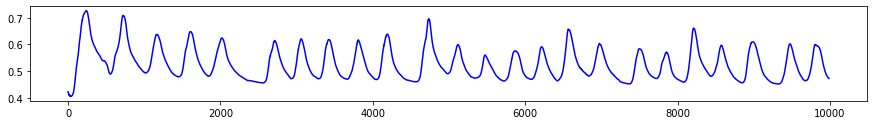

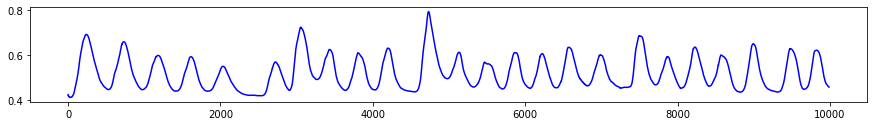

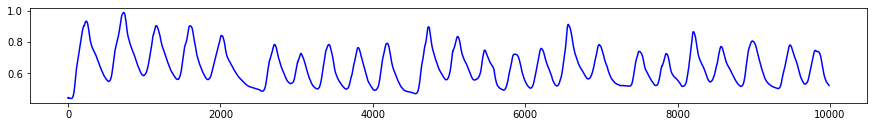

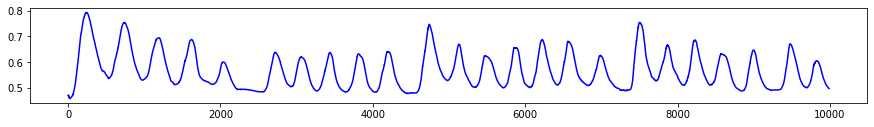

In [62]:
x = range(0, len(df_test))
fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,1)
plt.plot(x, df_test['1'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,2)
plt.plot(x, df_test['2'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,3)
plt.plot(x, df_test['3'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,4)
plt.plot(x, df_test['4'], 'b')
plt.show()

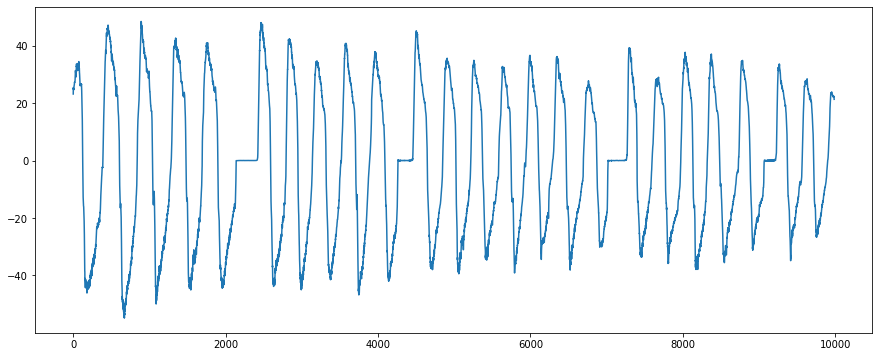

In [63]:
fig = plt.figure(figsize = (15, 6))
plt.plot(flow_test['Flow'])

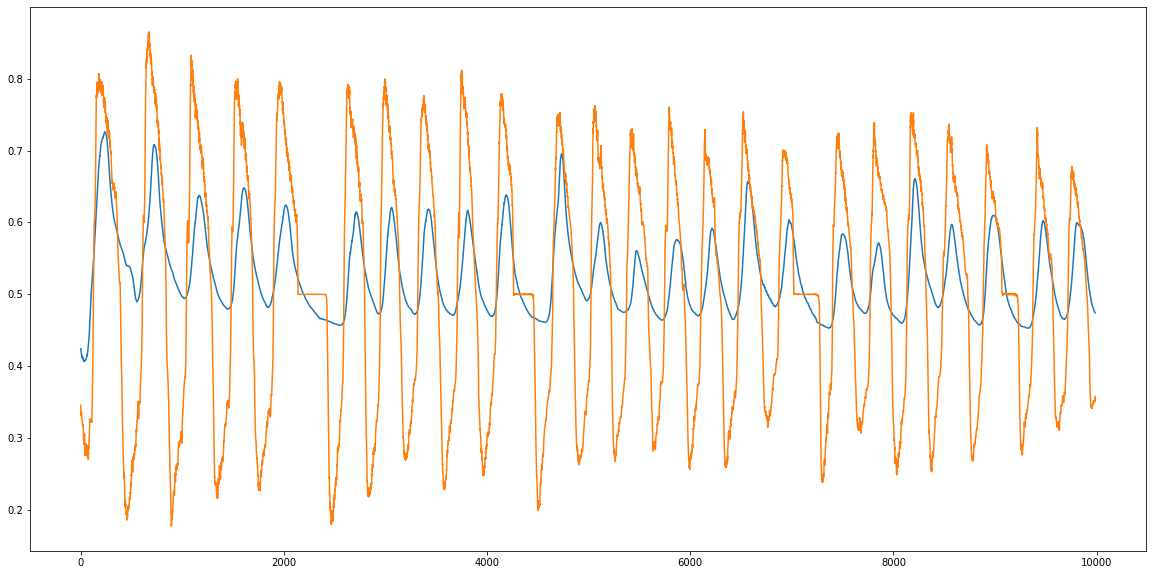

In [64]:
flow_test['a'] = (flow_test['Flow'] / 150) - 0.5
fig = plt.figure(figsize = (20, 10))
plt.plot(x, df_test['1'], x, flow_test['a']*-1)

In [65]:
flow_test.drop('a', inplace = True, axis = 1)

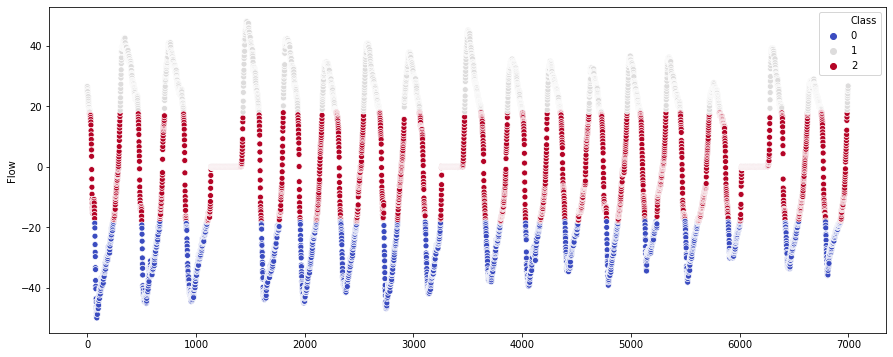

In [66]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow_test['Flow'][1000:8000], x = range(0, 7000), hue = df_test['Class'][1000:8000], palette = 'coolwarm')

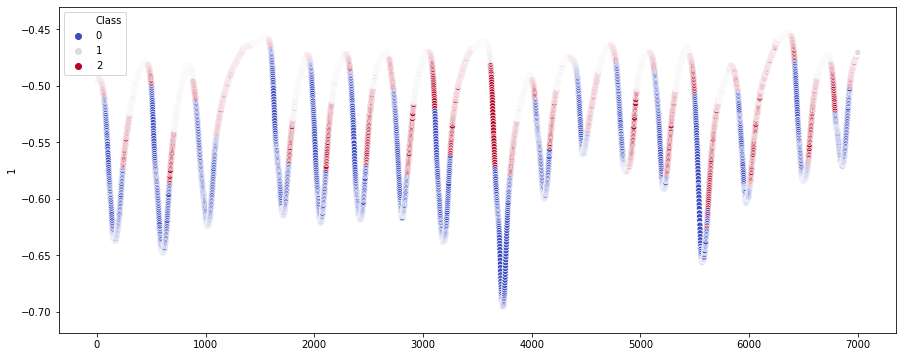

In [67]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = df_test['1'][1000:8000]*-1, x = range(0, 7000), hue = df_test['Class'][1000:8000], palette = 'coolwarm')

In [68]:
test_sensors = df_test.drop('Class', axis = 1)
test_sensors.drop('hours', inplace = True, axis = 1)
test_sensors.drop('minutes', inplace = True, axis = 1)
test_sensors.drop('seconds', inplace = True, axis = 1)

# Create the classification matrix
test_class = df_test['Class']
test_class = pd.DataFrame(test_class, index = None, columns = ['Class'])

#### model testing - random forest

In [69]:
test_predictions = rf_model.predict(test_sensors)
print(" accuracy = ", accuracy_score(test_class, test_predictions))
print(confusion_matrix(test_class, test_predictions))
print("\n")

print('Random Forest - Testing')
print('\n')
print(classification_report(test_class, test_predictions))

 accuracy =  0.6729402342576835
[[2818    0  457]
 [  71 1805 1360]
 [ 683  696 2099]]


Random Forest - Testing


              precision    recall  f1-score   support

           0       0.79      0.86      0.82      3275
           1       0.72      0.56      0.63      3236
           2       0.54      0.60      0.57      3478

    accuracy                           0.67      9989
   macro avg       0.68      0.67      0.67      9989
weighted avg       0.68      0.67      0.67      9989



In [70]:
testPredictions = classSwitch(test_predictions)
testClass = classSwitch(list(test_class['Class']))
print('Random Forest - Testing')
print('\n')
print(classification_report(testClass, testPredictions))

Random Forest - Testing


              precision    recall  f1-score   support

           0       0.78      0.88      0.83      5801
           1       0.80      0.66      0.72      4188
           2       0.00      0.00      0.00         0

    accuracy                           0.79      9989
   macro avg       0.53      0.51      0.52      9989
weighted avg       0.79      0.79      0.79      9989



/Users/mikefurr/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### model testing - deep learning

In [71]:
test_predictions = model.predict(test_sensors)

final_pred_test = []
for score in range(0, len(test_predictions)):
    final_pred_test.append(np.argmax(test_predictions[score]))

print('Keras Model - Testing')
print('\n')
print(classification_report(test_class, final_pred_test))

Keras Model - Testing


              precision    recall  f1-score   support

           0       0.70      0.50      0.59      3275
           1       0.70      0.81      0.75      3236
           2       0.45      0.51      0.48      3478

    accuracy                           0.60      9989
   macro avg       0.62      0.60      0.60      9989
weighted avg       0.61      0.60      0.60      9989



In [72]:
testPredictions = classSwitch(final_pred_test)
testClass = classSwitch(list(test_class['Class']))
print('Keras Model - Testing')
print('\n')
print(classification_report(testClass, testPredictions))

Keras Model - Testing


              precision    recall  f1-score   support

           0       0.90      0.74      0.81      5801
           1       0.71      0.89      0.79      4188
           2       0.00      0.00      0.00         0

    accuracy                           0.80      9989
   macro avg       0.54      0.54      0.53      9989
weighted avg       0.82      0.80      0.80      9989



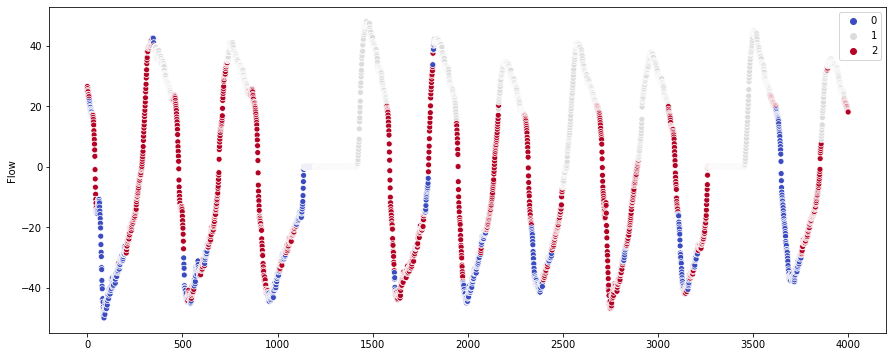

In [73]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow_test['Flow'][1000:5000], x = range(0, 4000), hue = final_pred_test[1000:5000], palette = 'coolwarm')

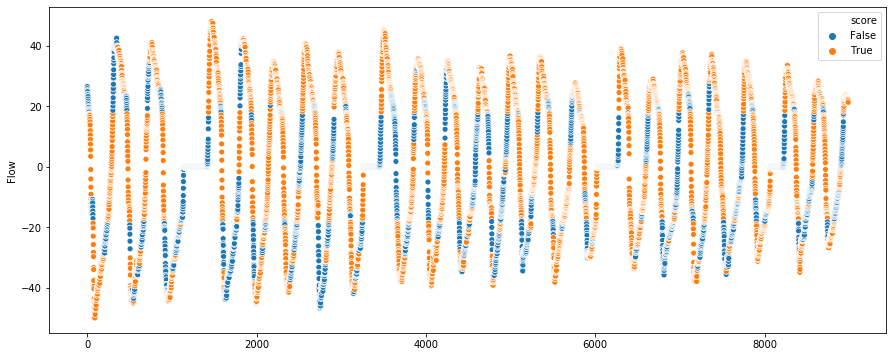

In [74]:
# Looking at where either model fails
test_class['score'] = test_class['Class'] == final_pred_test
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow_test['Flow'][1000:], x = range(0, 8989), hue = test_class['score'][1000:])

#### Save TFLite Model

In [75]:
keras_file = "model_5.h5"
keras.models.save_model(model, keras_file)
converter = tf.lite.TocoConverter.from_keras_model_file('model_5.h5')
tflite_model = converter.convert()
open("model_5.tflite", "wb").write(tflite_model)

W1112 12:32:40.188229 4589997504 deprecation.py:323] From <ipython-input-75-6fbccb3e59ee>:3: TocoConverter.from_keras_model_file (from tensorflow.lite.python.lite) is deprecated and will be removed in a future version.
Instructions for updating:
Use `lite.TFLiteConverter.from_keras_model_file` instead.
W1112 12:32:40.192870 4589997504 deprecation.py:506] From /Users/mikefurr/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1112 12:32:40.193724 4589997504 deprecation.py:506] From /Users/mikefurr/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for

88296